<a href="https://colab.research.google.com/github/Marmann/vae/blob/master/vae_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [139]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

#!pip install pushover
#from pushover import notify
#!pip install utils
#from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
bs = 32

In [0]:
# Load Data
#dataset = datasets.ImageFolder(root='./rollouts', transform=transforms.Compose([
#    transforms.Resize(64),
#    transforms.ToTensor(), 
#]))
#dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)
#len(dataset.imgs), len(dataloader)

In [0]:
ds = 'mnist'
#ds = 'fashionmnist'

In [144]:
if ds == 'fashionmnist':
  dataset = torchvision.datasets.FashionMNIST(root='./fashionmnist_data/',train=True, download=True, transform=transforms.Compose([
      transforms.Resize(64),
      transforms.ToTensor(), 
  ]))
else:
  dataset = torchvision.datasets.MNIST(root='./mnist_data/',train=True, download=True, transform=transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(), 
]))
  
dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=bs,
                                            shuffle=True)
len(dataloader)

1875

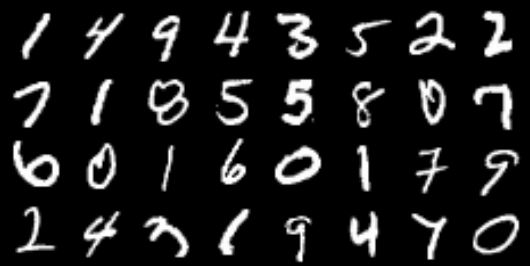

In [145]:
# Fixed input for debugging
fixed_x, _ = next(iter(dataloader))
save_image(fixed_x, 'real_image.png')

Image('real_image.png')

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [0]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [0]:
class BetaVAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32, beta = 1):
        super(BetaVAE, self).__init__()
        
        self.z_dim = z_dim        
        self.beta = beta
        
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        dtype=torch.cuda.FloatTensor
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        #print(mu.type(), std.type(), esp.type())
        z = mu + std * esp.type(dtype)
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar
      
    def loss_fn(self, recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
        # BCE = F.mse_loss(recon_x, x, size_average=False)
  
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

        return BCE + self.beta * KLD, BCE, KLD

In [0]:
image_channels = fixed_x.size(1)

In [0]:
beta = 150

In [0]:

model = BetaVAE(image_channels=image_channels, beta = beta).to(device)
#model.load_state_dict(torch.load('vae.torch', map_location='cpu'))

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

In [0]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [0]:
!rm -rfr reconstructed
!mkdir reconstructed

In [0]:
epochs = 1

In [156]:
dtype=torch.cuda.FloatTensor

for epoch in range(epochs):
    for idx, (images, _) in enumerate(dataloader):
        images = images.type(dtype)
        recon_images, mu, logvar = model(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                epochs, loss.data.item()/bs, bce.data.item()/bs, kld.data.item()/bs)
        if idx%100 == 0:
          print(to_print)

# notify to android when finished training
#notify(to_print, priority=1)

torch.save(model.state_dict(), 'vae.torch')

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/1] Loss: 3029.688 3029.688 0.000
Epoch[1/1] Loss: 1029.033 1028.888 0.145
Epoch[1/1] Loss: 820.005 819.684 0.320
Epoch[1/1] Loss: 631.339 631.123 0.216
Epoch[1/1] Loss: 543.553 543.340 0.213
Epoch[1/1] Loss: 526.867 526.663 0.204
Epoch[1/1] Loss: 510.286 510.082 0.204
Epoch[1/1] Loss: 474.240 474.045 0.195
Epoch[1/1] Loss: 490.552 490.365 0.187
Epoch[1/1] Loss: 449.684 449.485 0.199
Epoch[1/1] Loss: 501.620 501.441 0.178
Epoch[1/1] Loss: 477.528 477.337 0.190
Epoch[1/1] Loss: 427.222 427.040 0.182
Epoch[1/1] Loss: 434.956 434.775 0.181
Epoch[1/1] Loss: 422.914 422.740 0.174
Epoch[1/1] Loss: 428.992 428.817 0.175
Epoch[1/1] Loss: 426.415 426.239 0.176
Epoch[1/1] Loss: 454.993 454.820 0.172
Epoch[1/1] Loss: 445.403 445.232 0.170


In [0]:
def compare(x):
    recon_x, _, _ = model(x)
    return torch.cat([x, recon_x])

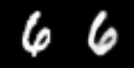

In [158]:
# sample = torch.randn(bs, 1024)
# compare_x = vae.decoder(sample)

# fixed_x, _ = next(iter(dataloader))
# fixed_x = fixed_x[:8]
fixed_x = dataset[randint(1, 100)][0].unsqueeze(0)
fixed_x = fixed_x.type(dtype)
compare_x = compare(fixed_x)

save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=700, unconfined=True))

In [0]:
import torch.optim as optim
import multiprocessing
import time
#import utils
import matplotlib.pyplot as plt

In [0]:


# generate n=num images using the model
def generate(model, num, device):
    model.eval()
    z = torch.randn(num, model.z_dim)
    #print(z)
    z = z.to(device)
    #print(z.type())
    with torch.no_grad():
        #return model.decode(z).cpu()
        d = model.decode(z)
        #print(d)
        return d


# returns pytorch tensor z
def get_z(im, model, device):
    model.eval()
    im = torch.unsqueeze(im, dim=0).to(device)

    with torch.no_grad():
        mu, logvar = model.encode(im)
        z = model.sample(mu, logvar)

    return z


def linear_interpolate(im1, im2, model, device):
    model.eval()
    z1 = get_z(im1, model, device)
    z2 = get_z(im2, model, device)

    factors = np.linspace(1, 0, num=10)
    result = []

    with torch.no_grad():

        for f in factors:
            z = (f * z1 + (1 - f) * z2).to(device)
            im = torch.squeeze(model.decode(z).cpu())
            result.append(im)

    return result


def get_average_z(ims, model, device):
    model.eval()
    z = torch.unsqueeze(torch.zeros(model.z_dim), dim=0)

    for im in ims:
        z += get_z(im, model, device).cpu()

    return z / len(ims)


def latent_arithmetic(im_z, attr_z, model, device):
    model.eval()

    factors = np.linspace(0, 1, num=10, dtype=float)
    result = []

    with torch.no_grad():

        for f in factors:
            z = im_z + (f * attr_z).type(torch.FloatTensor).to(device)
            im = torch.squeeze(model.decode(z).cpu())
            result.append(im)

    return result


def plot_loss(train_loss, test_loss, filepath):
    train_x, train_l = zip(*train_loss)
    test_x, test_l = zip(*test_loss)
    plt.figure()
    plt.title('Train Loss vs. Test Loss')
    plt.xlabel('episodes')
    plt.ylabel('loss')
    plt.plot(train_x, train_l, 'b', label='train_loss')
    plt.plot(test_x, test_l, 'r', label='test_loss')
    plt.legend()
    plt.savefig(filepath)


def get_attr_ims(attr, num=10):
    ids = prep.get_attr(attr_map, id_attr_map, attr)
    dataset = prep.ImageDiskLoader(ids)
    indices = np.random.randint(0, len(dataset), num)
    ims = [dataset[i] for i in indices]
    idx_ids = [dataset.im_ids[i] for i in indices]
    return ims, idx_ids


In [161]:
from google.colab import drive
drive.mount('/gdrive')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [162]:
%cd /gdrive/My\ Drive/colab

/gdrive/My Drive/colab


Using device cuda
latent size: 32


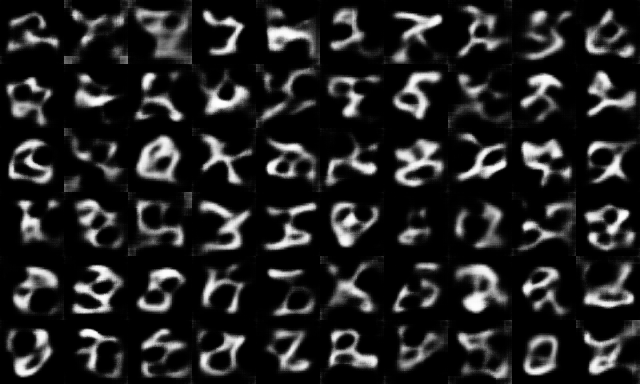

In [163]:


USE_CUDA = True
MODEL = 'dfc-300'
MODEL_PATH = './checkpoints/' + MODEL
LOG_PATH = './logs/' + MODEL + '/log.pkl'
OUTPUT_PATH = './samples/'
PLOT_PATH = './plots/' + MODEL
LATENT_SIZE = 100

use_cuda = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
# model = models.BetaVAE(z_dim=LATENT_SIZE).to(device)
#model = models.DFCVAE(z_dim=LATENT_SIZE).to(device)
#model = VAE(z_dim = LATENT_SIZE)
print('latent size:', model.z_dim)

samples = generate(model, 60, device)
#save_image(samples, OUTPUT_PATH + MODEL + '.png', padding=0, nrow=10)
image_path = OUTPUT_PATH + 'vae' + 'beta' + str(beta) + ds + 'z_dim' + str(model.z_dim) + 'epochs' + str(epochs) + '.png'
save_image(samples, image_path, padding=0, nrow=10)
display(Image(image_path, width=700, unconfined=True))

#save_image(compare_x.data.cpu(), 'sample_image.png')
#display(Image('sample_image.png', width=700, unconfined=True))



In [0]:
#attr_map, id_attr_map = prep.get_attributes()
# 
# if __name__ == "__main__":
# 
#     model.load_last_model(MODEL_PATH)
# 
#     '''
#     generate images using model
#     '''
#     # samples = generate(model, 60, device)
#     # save_image(samples, OUTPUT_PATH + MODEL + '.png', padding=0, nrow=10)
# 
#     train_losses, test_losses = utils.read_log(LOG_PATH, ([], []))
#     plot_loss(train_losses, test_losses, PLOT_PATH)
# 
#     '''
#     get image ids with corresponding attribute
#     '''
#     ims, im_ids = get_attr_ims('eyeglasses', num=20)
#     # utils.show_images(ims, titles=im_ids, tensor=True)
#     # print(im_ids)
# 
#     man_sunglasses_ids = ['172624.jpg', '164754.jpg', '089604.jpg', '024726.jpg']
#     man_ids = ['056224.jpg', '118398.jpg', '168342.jpg']
#     woman_smiles_ids = ['168124.jpg', '176294.jpg', '169359.jpg']
#     woman_ids = ['034343.jpg', '066393.jpg']
# 
#     man_sunglasses = prep.get_ims(man_sunglasses_ids)
#     man = prep.get_ims(man_ids)
#     woman_smiles = prep.get_ims(woman_smiles_ids)
#     woman = prep.get_ims(woman_ids)
# 
#     # utils.show_images(man_sunglasses, tensor=True)
#     # utils.show_images(man, tensor=True)
#     # utils.show_images(woman_smiles, tensor=True)
#     # utils.show_images(woman, tensor=True)
# 
#     '''
#     latent arithmetic
#     '''
#     man_z = get_z(man[0], model, device)
#     woman_z = get_z(woman[1], model, device)
#     sunglass_z = get_average_z(man_sunglasses, model, device) - get_average_z(man, model, device)
#     arith1 = latent_arithmetic(man_z, sunglass_z, model, device)
#     arith2 = latent_arithmetic(woman_z, sunglass_z, model, device)
# 
#     save_image(arith1 + arith2, OUTPUT_PATH + 'arithmetic-dfc' + '.png', padding=0, nrow=10)
# 
#     '''
#     linear interpolate
#     '''
#     inter1 = linear_interpolate(man[0], man[1], model, device)
#     inter2 = linear_interpolate(woman[0], woman_smiles[1], model, device)
#     inter3 = linear_interpolate(woman[1], woman_smiles[0], model, device)
# 
#     save_image(inter1 + inter2 + inter3, OUTPUT_PATH + 'interpolate-dfc' + '.png', padding=0, nrow=10)